In [1]:
from torchvision import datasets, transforms

full = datasets.MNIST(root='./data',
                       train=True,
                       download=True,
                       transform=transforms.ToTensor())
test = datasets.MNIST(root='./data',
                      train=False,
                      download=True,
                      transform=transforms.ToTensor())
print(len(full), len(test))

60000 10000


In [2]:
image, label = full[0]
print(image.shape)
print(image.max().item())
print(label)

torch.Size([1, 28, 28])
1.0
5


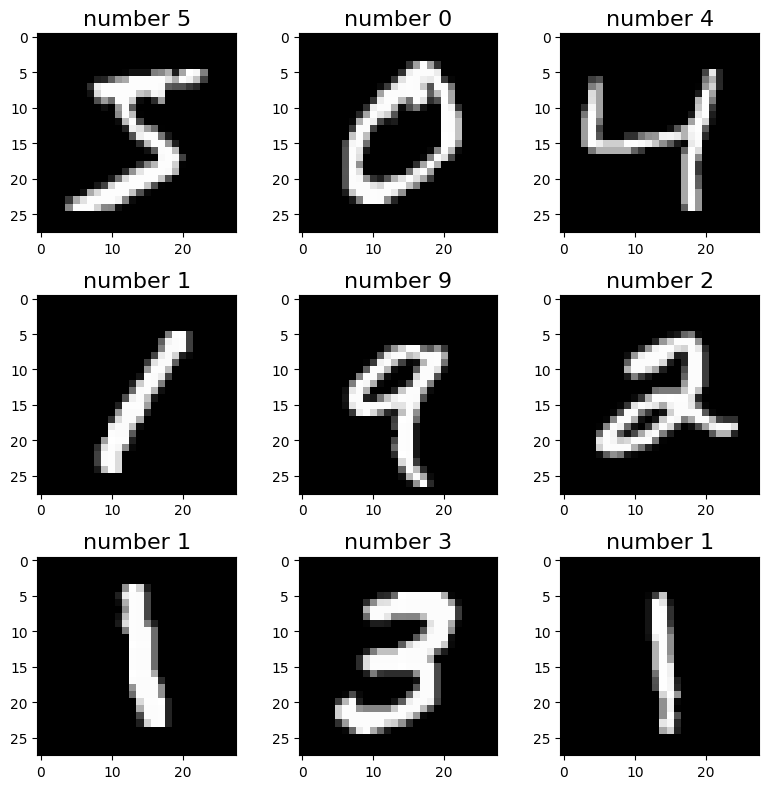

In [3]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 8))
for i in range(9):
    image, label = full[i]
    image = image[0, :, :]
    plt.subplot(3, 3, i+1)
    plt.imshow(image, cmap='gray', interpolation='none')
    plt.title("number {}".format(label), fontsize=16)

plt.tight_layout()
plt.show()

In [4]:
import torch
from torch.utils.data import random_split
from torch.utils.data import DataLoader

batch_size = 128
valid_size = 10000
train_size = len(full) - valid_size
train, valid = random_split(
    full, [train_size , valid_size], 
    generator=torch.Generator().manual_seed(42)
)
print(len(train), len(valid), len(test))

train_loader = DataLoader(train, batch_size=batch_size, shuffle=True)
data_iter = iter(train_loader)
image, label = next(data_iter)
print(image.shape)
print(label.shape)

50000 10000 10000
torch.Size([128, 1, 28, 28])
torch.Size([128])


In [5]:
from torch import nn

class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()

        self.c1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5, padding=2)
        self.p1 = nn.AvgPool2d(kernel_size=2, stride=2)
        self.c2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5)
        self.p2 = nn.AvgPool2d(kernel_size=2, stride=2)

        self.flatten = nn.Flatten()
        self.f1 = nn.Linear(16 * 5 * 5, 120)  # 16 channels * 5x5 feature map
        self.f2 = nn.Linear(120, 84)
        self.f3 = nn.Linear(84, 10)

    def forward(self, x):
        x = nn.Sigmoid()(self.c1(x))
        x = self.p1(x)
        x = nn.Sigmoid()(self.c2(x))
        x = self.p2(x)
        x = self.flatten(x)
        x = nn.Sigmoid()(self.f1(x))
        x = nn.Sigmoid()(self.f2(x))
        x = self.f3(x)
        return x

In [6]:
model = LeNet()
for name, param in model.named_parameters():
    print(name, param.size())

c1.weight torch.Size([6, 1, 5, 5])
c1.bias torch.Size([6])
c2.weight torch.Size([16, 6, 5, 5])
c2.bias torch.Size([16])
f1.weight torch.Size([120, 400])
f1.bias torch.Size([120])
f2.weight torch.Size([84, 120])
f2.bias torch.Size([84])
f3.weight torch.Size([10, 84])
f3.bias torch.Size([10])


In [7]:
from torchinfo import summary

print(summary(model, (1, 1, 28, 28)))

Layer (type:depth-idx)                   Output Shape              Param #
LeNet                                    [1, 10]                   --
├─Conv2d: 1-1                            [1, 6, 28, 28]            156
├─AvgPool2d: 1-2                         [1, 6, 14, 14]            --
├─Conv2d: 1-3                            [1, 16, 10, 10]           2,416
├─AvgPool2d: 1-4                         [1, 16, 5, 5]             --
├─Flatten: 1-5                           [1, 400]                  --
├─Linear: 1-6                            [1, 120]                  48,120
├─Linear: 1-7                            [1, 84]                   10,164
├─Linear: 1-8                            [1, 10]                   850
Total params: 61,706
Trainable params: 61,706
Non-trainable params: 0
Total mult-adds (Units.MEGABYTES): 0.42
Input size (MB): 0.00
Forward/backward pass size (MB): 0.05
Params size (MB): 0.25
Estimated Total Size (MB): 0.30


In [8]:
if torch.cuda.is_available():
    gpu_count = torch.cuda.device_count()
    print(f"可用的GPU数量: {gpu_count}")

    for i in range(gpu_count):
        gpu_name = torch.cuda.get_device_name(i)
        print(f"GPU {i}: {gpu_name}")
else:
    print("没有可用的GPU")

可用的GPU数量: 1
GPU 0: Tesla T4


In [11]:
import numpy as np
from skorch import NeuralNetClassifier
from skorch.helper import predefined_split

y_train = np.array([y for x, y in iter(train)])
net = NeuralNetClassifier(
    LeNet,
    criterion=nn.CrossEntropyLoss,
    max_epochs=10,
    optimizer=torch.optim.Adam,
    batch_size=1024,
    lr=0.005,
    train_split=predefined_split(valid),
    device='cuda' if torch.cuda.is_available() else 'cpu'
)

net.fit(X=train, y=y_train)

  epoch    train_loss    valid_acc    valid_loss     dur
-------  ------------  -----------  ------------  ------
      1        2.2857       0.2382        2.1403  5.9573
      2        1.4777       0.6891        0.8846  6.0444
      3        0.6659       0.8435        0.5064  5.8092
      4        0.3925       0.9048        0.3182  6.0162
      5        0.2696       0.9252        0.2475  5.8981
      6        0.2156       0.9352        0.2099  5.9658
      7        0.1783       0.9454        0.1772  6.0639
      8        0.1510       0.9533        0.1539  5.7912
      9        0.1297       0.9595        0.1360  5.9404
     10        0.1132       0.9635        0.1219  5.9326


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LeNet(
    (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (p1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (c2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (p2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (f1): Linear(in_features=400, out_features=120, bias=True)
    (f2): Linear(in_features=120, out_features=84, bias=True)
    (f3): Linear(in_features=84, out_features=10, bias=True)
  ),
)

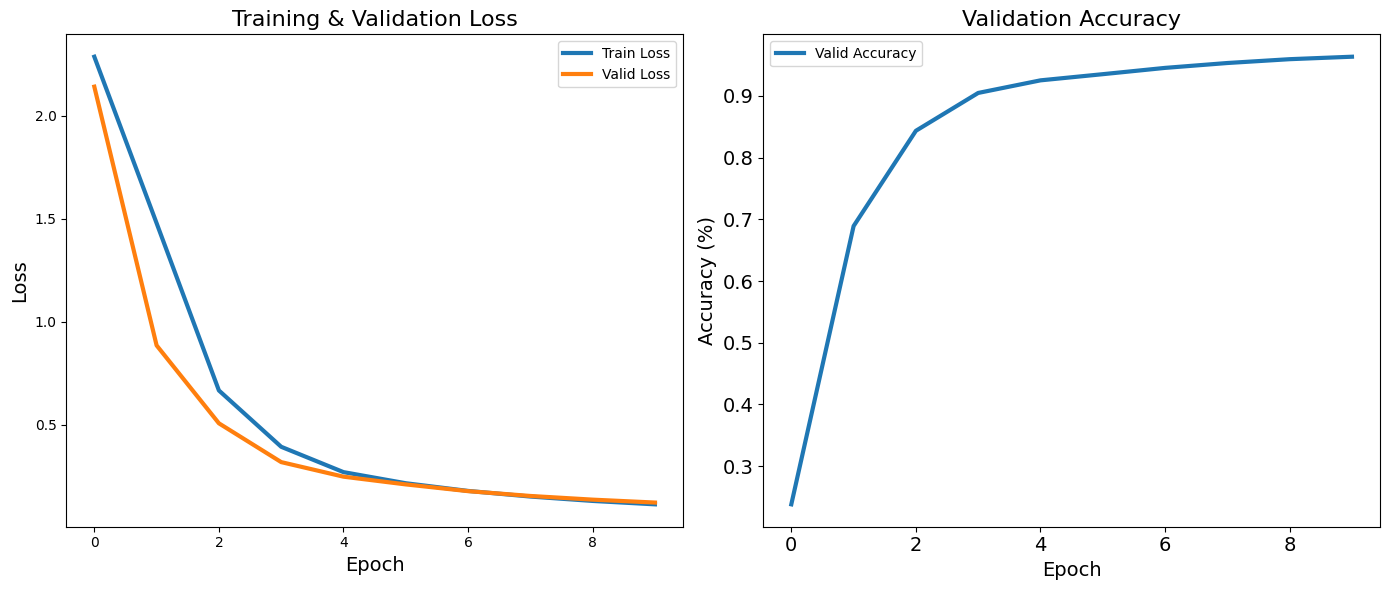

In [13]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(net.history[:, 'train_loss'], label='Train Loss', linewidth=3)
ax1.plot(net.history[:, 'valid_loss'], label='Valid Loss', linewidth=3)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('Training & Validation Loss', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax1.legend()

ax2.plot(net.history[:, 'valid_acc'], label='Valid Accuracy', linewidth=3)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2.set_title('Validation Accuracy', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax2.legend()

plt.tight_layout() 
plt.show()

In [14]:
from sklearn.metrics import accuracy_score

y_pred = net.predict(test) 
y_true = test.targets     
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9697


In [15]:
from skorch import NeuralNetClassifier
from skorch.callbacks import EarlyStopping, Checkpoint, EpochScoring, LRScheduler, ProgressBar
from torch.optim.lr_scheduler import CosineAnnealingLR

epochs = 70
bar = ProgressBar()
lr_scheduler = LRScheduler(policy=CosineAnnealingLR, T_max=epochs)
early_stopping = EarlyStopping(monitor='valid_acc', lower_is_better=False, patience=6)
train_acc = EpochScoring(name='train_acc', scoring='accuracy', on_train=True)
check_point = Checkpoint(
    dirname='./data/checkpoints', f_params='best_model.pt', 
    monitor='valid_acc_best', load_best=True
)
callbacks = [bar, lr_scheduler, early_stopping, train_acc, check_point]

net = NeuralNetClassifier(
    LeNet,
    criterion=nn.CrossEntropyLoss,
    optimizer=torch.optim.Adam,
    lr=0.005,
    batch_size=1024,
    max_epochs=epochs,
    train_split=predefined_split(valid),
    device='cuda' if torch.cuda.is_available() else 'cpu',
    callbacks=callbacks
)
net.fit(X=train, y=y_train)

  0%|          | 0/59 [00:00<?, ?it/s]

  epoch    train_acc    train_loss    valid_acc    valid_loss    cp      lr     dur
-------  -----------  ------------  -----------  ------------  ----  ------  ------
      1       0.1467        2.2754       0.2744        2.0740     +  0.0050  6.0809


  0%|          | 0/59 [00:00<?, ?it/s]

      2       0.5706        1.3252       0.7709        0.7129     +  0.0050  5.9458


  0%|          | 0/59 [00:00<?, ?it/s]

      3       0.8392        0.5012       0.8845        0.3769     +  0.0050  6.2834


  0%|          | 0/59 [00:00<?, ?it/s]

      4       0.9151        0.2849       0.9308        0.2336     +  0.0050  5.9222


  0%|          | 0/59 [00:00<?, ?it/s]

      5       0.9462        0.1831       0.9501        0.1617     +  0.0050  6.3452


  0%|          | 0/59 [00:00<?, ?it/s]

      6       0.9610        0.1344       0.9575        0.1361     +  0.0049  5.9462


  0%|          | 0/59 [00:00<?, ?it/s]

      7       0.9688        0.1073       0.9670        0.1098     +  0.0049  5.9428


  0%|          | 0/59 [00:00<?, ?it/s]

      8       0.9739        0.0897       0.9704        0.0969     +  0.0049  6.2328


  0%|          | 0/59 [00:00<?, ?it/s]

      9       0.9768        0.0778       0.9731        0.0879     +  0.0048  5.9426


  0%|          | 0/59 [00:00<?, ?it/s]

     10       0.9791        0.0690       0.9757        0.0808     +  0.0048  6.1084


  0%|          | 0/59 [00:00<?, ?it/s]

     11       0.9810        0.0624       0.9779        0.0745     +  0.0048  6.1130


  0%|          | 0/59 [00:00<?, ?it/s]

     12       0.9830        0.0560       0.9782        0.0696     +  0.0047  5.9595


  0%|          | 0/59 [00:00<?, ?it/s]

     13       0.9850        0.0497       0.9793        0.0655     +  0.0046  6.3043


  0%|          | 0/59 [00:00<?, ?it/s]

     14       0.9865        0.0452       0.9802        0.0628     +  0.0046  5.9077


  0%|          | 0/59 [00:00<?, ?it/s]

     15       0.9877        0.0416       0.9810        0.0604     +  0.0045  6.1037


  0%|          | 0/59 [00:00<?, ?it/s]

     16       0.9889        0.0384       0.9814        0.0583     +  0.0045  5.9676


  0%|          | 0/59 [00:00<?, ?it/s]

     17       0.9896        0.0356       0.9822        0.0564     +  0.0044  6.1457


  0%|          | 0/59 [00:00<?, ?it/s]

     18       0.9904        0.0332       0.9823        0.0547     +  0.0043  6.1509


  0%|          | 0/59 [00:00<?, ?it/s]

     19       0.9913        0.0310       0.9830        0.0532     +  0.0042  6.0088


  0%|          | 0/59 [00:00<?, ?it/s]

     20       0.9920        0.0292       0.9832        0.0519     +  0.0041  6.0998


  0%|          | 0/59 [00:00<?, ?it/s]

     21       0.9927        0.0276       0.9834        0.0510     +  0.0041  6.0134


  0%|          | 0/59 [00:00<?, ?it/s]

     22       0.9930        0.0262       0.9830        0.0508        0.0040  6.0409


  0%|          | 0/59 [00:00<?, ?it/s]

     23       0.9933        0.0249       0.9829        0.0515        0.0039  6.1644


  0%|          | 0/59 [00:00<?, ?it/s]

     24       0.9937        0.0237       0.9828        0.0528        0.0038  6.2065


  0%|          | 0/59 [00:00<?, ?it/s]

     25       0.9941        0.0225       0.9827        0.0536        0.0037  6.1653


  0%|          | 0/59 [00:00<?, ?it/s]

     26       0.9942        0.0213       0.9826        0.0531        0.0036  6.0101


  0%|          | 0/59 [00:00<?, ?it/s]

Stopping since valid_acc has not improved in the last 6 epochs.


<class 'skorch.classifier.NeuralNetClassifier'>[initialized](
  module_=LeNet(
    (c1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (p1): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (c2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (p2): AvgPool2d(kernel_size=2, stride=2, padding=0)
    (flatten): Flatten(start_dim=1, end_dim=-1)
    (f1): Linear(in_features=400, out_features=120, bias=True)
    (f2): Linear(in_features=120, out_features=84, bias=True)
    (f3): Linear(in_features=84, out_features=10, bias=True)
  ),
)

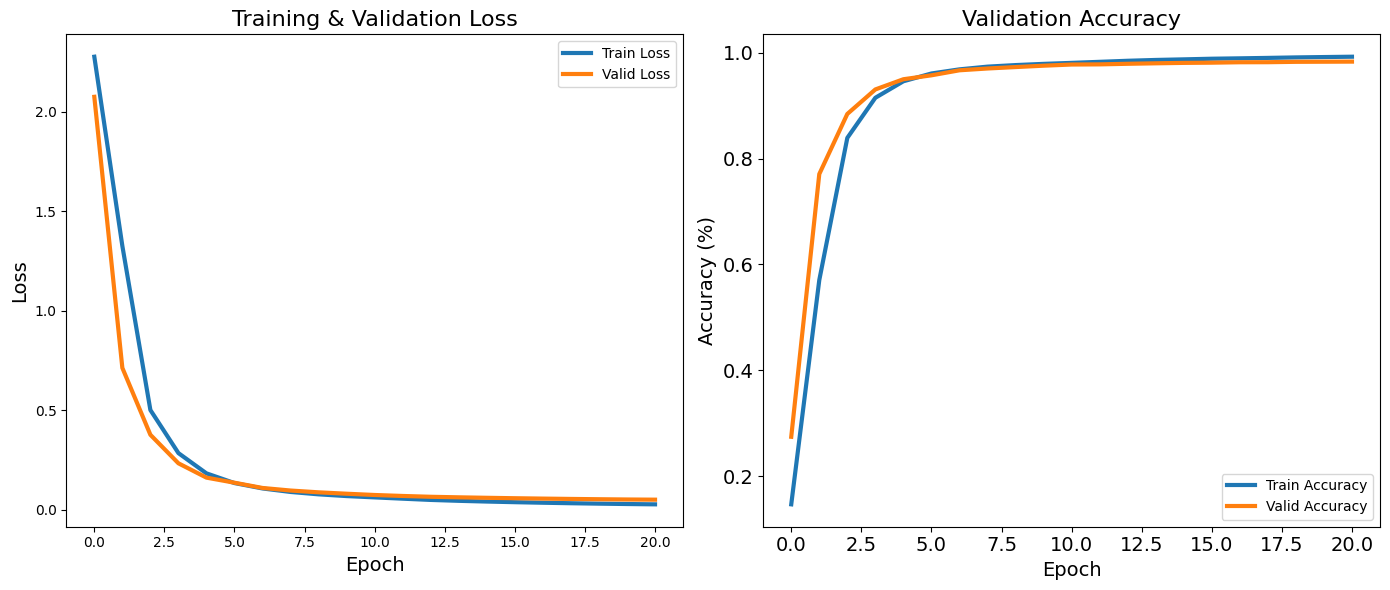

In [16]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.plot(net.history[:, 'train_loss'], label='Train Loss', linewidth=3)
ax1.plot(net.history[:, 'valid_loss'], label='Valid Loss', linewidth=3)
ax1.set_xlabel('Epoch', fontsize=14)
ax1.set_ylabel('Loss', fontsize=14)
ax1.set_title('Training & Validation Loss', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax1.legend()

ax2.plot(net.history[:, 'train_acc'], label='Train Accuracy', linewidth=3)
ax2.plot(net.history[:, 'valid_acc'], label='Valid Accuracy', linewidth=3)
ax2.set_xlabel('Epoch', fontsize=14)
ax2.set_ylabel('Accuracy (%)', fontsize=14)
ax2.set_title('Validation Accuracy', fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
ax2.legend()

plt.tight_layout() 
plt.show()

In [17]:
y_pred = net.predict(test) 
y_true = test.targets     
test_accuracy = accuracy_score(y_true, y_pred)
print(f"Test Accuracy: {test_accuracy:.4f}")

Test Accuracy: 0.9869


Confusion Matrix:
 [[ 971    0    1    0    0    0    3    1    3    1]
 [   0 1127    1    0    1    0    2    1    3    0]
 [   0    1 1021    2    1    0    1    3    3    0]
 [   0    0    2  997    0    0    0    6    2    3]
 [   0    0    2    0  972    0    5    0    0    3]
 [   1    0    0    5    0  882    1    1    0    2]
 [   3    2    1    0    2    2  945    0    3    0]
 [   1    3    4    1    0    0    0 1012    2    5]
 [   4    0    3    2    1    1    1    2  956    4]
 [   2    4    0    0    8    2    0    6    1  986]]


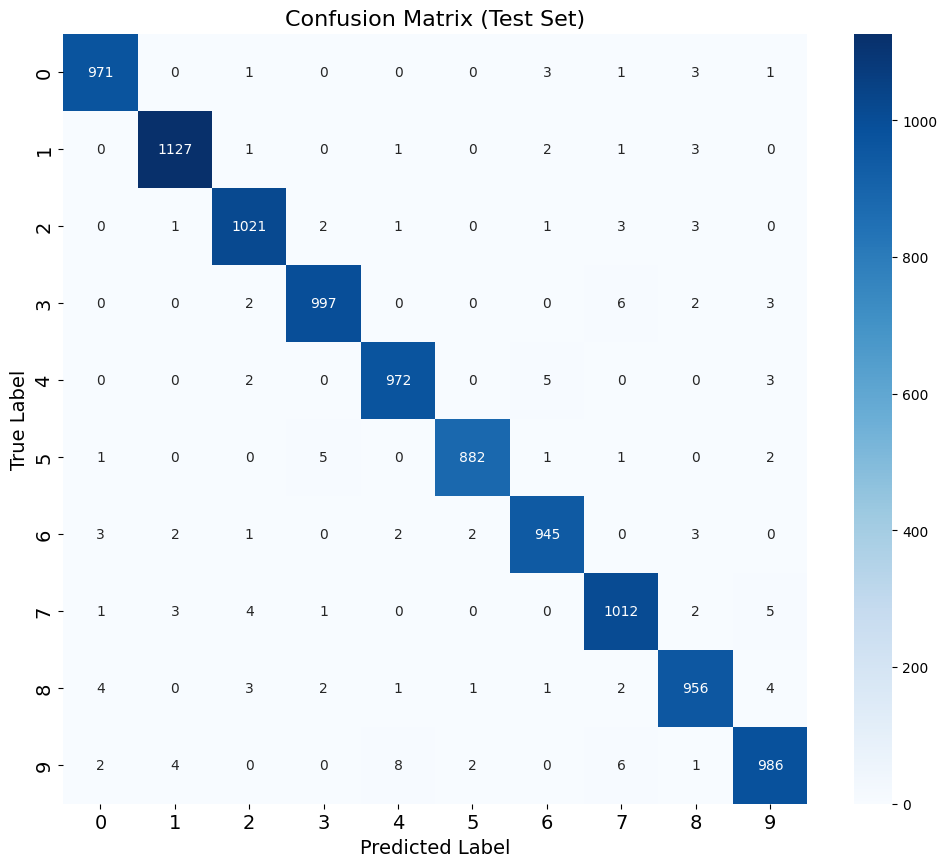

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm, 
    annot=True, 
    fmt="d", 
    cmap="Blues",
    annot_kws={"size": 10},
)
plt.xlabel("Predicted Label", fontsize=14)
plt.ylabel("True Label", fontsize=14)
plt.title("Confusion Matrix (Test Set)", fontsize=16)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

In [19]:
y_true = np.asarray(test.targets)          
y_pred = net.predict(test)                 
y_prob = net.predict_proba(test)          
wrong_idx = np.where(y_pred != y_true)[0]
error_list = []
for i in wrong_idx:
    features, _ = test[i]                  
    error_list.append({
        "features": features,              
        "true_label": int(y_true[i]),
        "pred_label": int(y_pred[i]),
        "probabilities": y_prob[i]      
    })

print(len(error_list))

131


In [20]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
checkpoint = torch.load('./data/checkpoints/best_model.pt', map_location=device)
loader = DataLoader(test, batch_size=1024, shuffle=False)

load_model = LeNet()
load_model.to(device)
load_model.load_state_dict(checkpoint)
load_model.eval()

all_preds = []     
all_probs = []     
all_labels = []    
with torch.no_grad():             
    for x, y in loader:                  
        x = x.to(device, non_blocking=True)
        y = y.to(device, non_blocking=True)

        logits = load_model(x)                
        probs = logits.softmax(dim=1)   
        preds = probs.argmax(1)         

        all_probs.append(probs.cpu())
        all_preds.append(preds.cpu())
        all_labels.append(y.cpu())

all_probs = torch.cat(all_probs)         
all_preds = torch.cat(all_preds)         
all_labels = torch.cat(all_labels)
probs_np = all_probs.numpy()
max_probs = probs_np.max(axis=1)
preds_np = all_preds.numpy()
labels_np = all_labels.numpy()

print(f'max_probs:  {max_probs[:5]}')
print(f'preds:  {preds_np[:5]}')
print(f'labels: {labels_np[:5]}')

max_probs:  [0.9998965  0.99962556 0.99985075 0.9989354  0.9984012 ]
preds:  [7 2 1 0 4]
labels: [7 2 1 0 4]


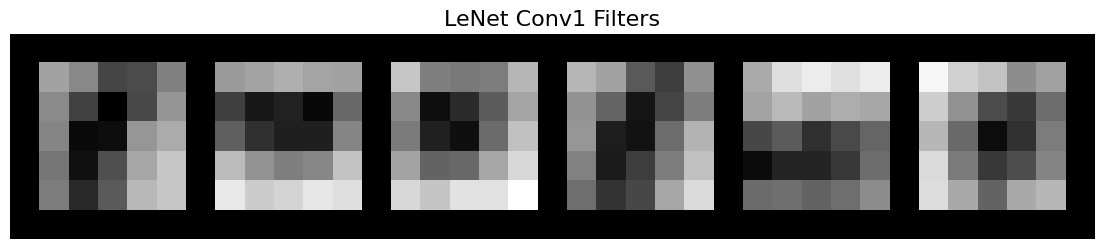

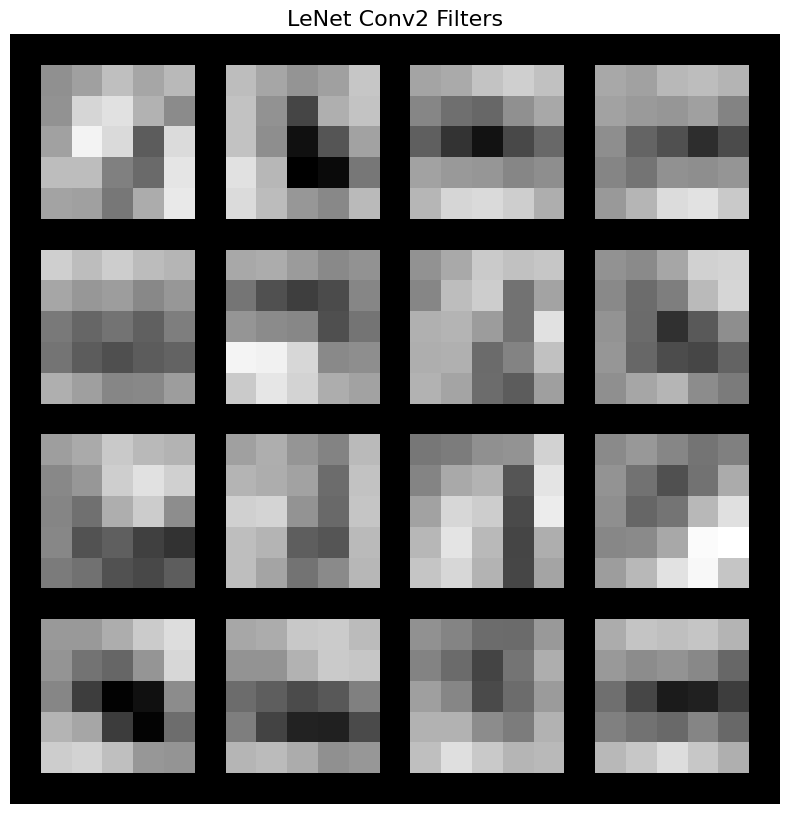

In [21]:
import matplotlib.pyplot as plt
from torchvision.utils import make_grid

w1 = load_model.c1.weight.data.clone().cpu()          
grid1 = make_grid(w1, nrow=6, normalize=True, padding=1)  

plt.figure(figsize=(14, 4))
plt.imshow(grid1.permute(1, 2, 0))  
plt.axis('off')
plt.title("LeNet Conv1 Filters", fontsize=16)
plt.show()

w2 = load_model.c2.weight.data.clone().cpu()[:, 0, :, :].unsqueeze(1)  
grid2 = make_grid(w2, nrow=4, normalize=True, padding=1)              

plt.figure(figsize=(10, 10))
plt.imshow(grid2.permute(1, 2, 0))
plt.axis('off')
plt.title("LeNet Conv2 Filters", fontsize=16)
plt.show()